In [48]:
import itertools
import random

import torch
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean
from collections import defaultdict

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *
from networkx.algorithms.centrality import degree_centrality
import pickle
from itertools import zip_longest
from torch_geometric.utils import degree
from torch_geometric.utils import degree, from_networkx, to_networkx


from custom.utils import *

In [2]:
def max_common_subgraph(data1, data2, mp):
    def pyg_to_nx(data):
        return to_networkx(data, to_undirected=True)

    def nx_to_pyg(G):
        return from_networkx(G)

    def mc_split(G1, G2, mp):
        incumbent = []
        max_size = 0

        def search(mapping, future, incumbent):
            nonlocal max_size
            if len(mapping) > max_size:
                max_size = len(mapping)
                incumbent = mapping[:]
            bound = len(mapping) + sum(min(len(g), len(h)) for g, h in future)
            if bound <= max_size:
                return incumbent

            G, H = min(future, key=lambda x: max(len(x[0]), len(x[1])))
            v = max(G, key=lambda x: G1.degree[x])
            for w in H:
                if (v, w) not in mp:
                    continue
                future_prime = []
                for G_prime, H_prime in future:
                    G_prime_adj = [
                        u for u in G_prime if u != v and u in G1.neighbors(v)
                    ]
                    H_prime_adj = [
                        u for u in H_prime if u != w and u in G2.neighbors(w)
                    ]
                    if G_prime_adj and H_prime_adj:
                        future_prime.append((G_prime_adj, H_prime_adj))
                    G_prime_non_adj = [
                        u for u in G_prime if u != v and u not in G1.neighbors(v)
                    ]
                    H_prime_non_adj = [
                        u for u in H_prime if u != w and u not in G2.neighbors(w)
                    ]
                    if G_prime_non_adj and H_prime_non_adj:
                        future_prime.append((G_prime_non_adj, H_prime_non_adj))
                incumbent = search(mapping + [(v, w)], future_prime, incumbent)
            G_prime = [u for u in G if u != v]
            future.remove((G, H))
            if G_prime:
                future.append((G_prime, H))
            incumbent = search(mapping, future, incumbent)
            return incumbent

        future = [(list(G1.nodes), list(G2.nodes))]
        incumbent = search([], future, incumbent)

        return incumbent

    G1 = pyg_to_nx(data1)
    G2 = pyg_to_nx(data2)
    mapping = mc_split(G1, G2, mp)
    common_nodes = [v for v, _ in mapping]
    subgraph = G1.subgraph(common_nodes)
    return nx_to_pyg(subgraph)

In [51]:
import networkx as nx
import torch
from torch_geometric.utils import degree
import time


class MCS:
    def __init__(self, mp):
        self.mp = mp
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.time_limit = 5
        self.start_time = None

    def find_mcs(self, G1, G2):
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.start_time = time.time()

        G1_degrees = degree(G1.edge_index[0], G1.num_nodes)
        G2_degrees = degree(G2.edge_index[0], G2.num_nodes)

        nodes1 = list(range(G1.num_nodes))
        nodes2 = list(range(G2.num_nodes))

        for n1 in nodes1:
            for n2 in nodes2:
                if (n1, n2) in self.mp:
                    M = {n1: n2}
                    neighbors1 = set(G1.edge_index[1][G1.edge_index[0] == n1].tolist())
                    neighbors2 = set(G2.edge_index[1][G2.edge_index[0] == n2].tolist())
                    self.match(
                        G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2
                    )
        return self.all_mappings

    def match(self, G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2):
        if time.time() - self.start_time > self.time_limit:
            return

        state = (frozenset(M.items()), frozenset(neighbors1), frozenset(neighbors2))
        if state in self.visited:
            return
        self.visited.add(state)

        edge_count = self.count_edges(M, G1, G2)

        if len(M) > self.max_size or (
            len(M) == self.max_size and edge_count > self.edge_count
        ):
            self.max_size = len(M)
            self.edge_count = edge_count
            self.all_mappings = [M.copy()]
            self.unique_mappings = {self.canonical_form(M)}
        elif len(M) == self.max_size and edge_count == self.edge_count:
            canonical = self.canonical_form(M)
            if canonical not in self.unique_mappings:
                self.all_mappings.append(M.copy())
                self.unique_mappings.add(canonical)

        candidates1 = sorted(neighbors1, key=lambda n: -G1_degrees[n].item())
        candidates2 = sorted(neighbors2, key=lambda n: -G2_degrees[n].item())

        for n1 in candidates1:
            if n1 not in M:
                for n2 in candidates2:
                    if n2 not in M.values() and self.feasible(n1, n2, M, G1, G2):
                        M[n1] = n2
                        new_neighbors1 = set(
                            G1.edge_index[1][G1.edge_index[0] == n1].tolist()
                        )
                        new_neighbors2 = set(
                            G2.edge_index[1][G2.edge_index[0] == n2].tolist()
                        )
                        neighbors1.update(new_neighbors1 - set(M.keys()))
                        neighbors2.update(new_neighbors2 - set(M.values()))
                        self.match(
                            G1,
                            G2,
                            M,
                            G1_degrees,
                            G2_degrees,
                            neighbors1,
                            neighbors2,
                        )
                        del M[n1]
                        neighbors1.difference_update(new_neighbors1)
                        neighbors2.difference_update(new_neighbors2)

    def feasible(self, n1, n2, M, G1, G2):
        if not torch.equal(G1.x[n1], G2.x[n2]):
            return False
        if (n1, n2) not in self.mp:
            return False

        count1 = 0
        count2 = 0

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if neighbor.item() in M:
                count1 += 1

        for neighbor in G2.edge_index[1][G2.edge_index[0] == n2]:
            if neighbor.item() in M.values():
                count2 += 1

        if count1 != count2:
            return False

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if (
                neighbor.item() in M
                and M[neighbor.item()]
                not in G2.edge_index[1][G2.edge_index[0] == n2].tolist()
            ):
                return False

        return True

    def count_edges(self, M, G1, G2):
        edge_count = 0
        for u1, v1 in M.items():
            for u2, v2 in M.items():
                if u1 != u2:
                    u1_v1_exists = (
                        (G1.edge_index[0] == u1) & (G1.edge_index[1] == u2)
                    ).any() or (
                        (G1.edge_index[0] == u2) & (G1.edge_index[1] == u1)
                    ).any()
                    u2_v2_exists = (
                        (G2.edge_index[0] == v1) & (G2.edge_index[1] == v2)
                    ).any() or (
                        (G2.edge_index[0] == v2) & (G2.edge_index[1] == v1)
                    ).any()
                    if u1_v1_exists and u2_v2_exists:
                        edge_count += 1
        return edge_count

    def canonical_form(self, M):
        G1_set = set(M.keys())
        G2_set = set(M.values())
        return (frozenset(G1_set), frozenset(G2_set))

In [4]:
def plot_attentions(graph1, graph2, attention_pairs, title=""):
    def get_node_labels(graph):
        node_labels = {}
        for node in range(graph.num_nodes):
            node_labels[node] = node
        return node_labels

    G1 = to_networkx(graph1, to_undirected=True)
    G2 = to_networkx(graph2, to_undirected=True)

    G_combined = nx.Graph()

    for n, d in G1.nodes(data=True):
        G_combined.add_node(n, **d)
    for n, d in G2.nodes(data=True):
        G_combined.add_node(n + len(G1.nodes), **d)

    G_combined.add_edges_from([(u, v) for u, v in G1.edges()])
    G_combined.add_edges_from(
        [(u + len(G1.nodes), v + len(G1.nodes)) for u, v in G2.edges()]
    )

    G_plain = G_combined.copy()

    for node1, node2 in attention_pairs:
        G_combined.add_edge(node1, node2 + len(G1.nodes))

    pos_G1 = nx.spring_layout(G1)
    pos_G2 = nx.spring_layout(G2)

    for key in pos_G1.keys():
        pos_G1[key] = [pos_G1[key][0] - 1.5, pos_G1[key][1]]

    for key in pos_G2.keys():
        pos_G2[key] = [pos_G2[key][0] + 1.5, pos_G2[key][1]]

    pos_combined = {**pos_G1, **{k + len(G1.nodes): v for k, v in pos_G2.items()}}

    node_labels_G1 = get_node_labels(graph1)
    node_labels_G2 = get_node_labels(graph2)
    node_labels_combined = {
        **node_labels_G1,
        **{k + len(G1.nodes): v for k, v in node_labels_G2.items()},
    }

    plt.figure(figsize=(12, 6))
    plt.gcf().patch.set_alpha(0)

    nx.draw(
        G_plain,
        pos=pos_combined,
        with_labels=False,
        labels=node_labels_combined,
        node_color="#3b8bc2",
        edge_color="black",
        node_size=500,
    )

    # attention_edges = [
    #     (node1, node2 + len(G1.nodes)) for node1, node2 in attention_pairs
    # ]
    # nx.draw_networkx_edges(
    #     G_combined,
    #     pos=pos_combined,
    #     edgelist=attention_edges,
    #     edge_color="lightgrey",
    # )

    plt.title(title)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.gcf().patch.set_alpha(0)

    nx.draw(
        G_combined,
        pos=pos_combined,
        with_labels=False,
        labels=node_labels_combined,
        node_color="#3b8bc2",
        edge_color="black",
        node_size=500,
    )

    attention_edges = [
        (node1, node2 + len(G1.nodes)) for node1, node2 in attention_pairs
    ]
    nx.draw_networkx_edges(
        G_combined,
        pos=pos_combined,
        edgelist=attention_edges,
        edge_color="lightgrey",
    )

    plt.title(title)
    plt.show()

In [5]:
def loop(graph1, graph2, attentions, t):
    most_nodes = 0
    largest_summary = None
    for i in range(3):
        attention_nodes = extract_dynamic_attention_nodes(attentions, threshold=t)
        mp = mutual_pairs(attention_nodes, i)
        vf2 = MCS(mp)
        patterns = vf2.find_mcs(graph1, graph2)

        if patterns != []:
            pattern = patterns[0]

            g1_subgraph, g2_subgraph = create_subgraphs(pattern, graph1, graph2)

            if (
                nx.is_isomorphic(
                    to_networkx(g1_subgraph, to_undirected=True),
                    to_networkx(g2_subgraph, to_undirected=True),
                )
                and len(pattern) > 2
            ):
                summary = g1_subgraph
                

                if len(pattern) > most_nodes:
                    most_nodes = len(pattern)
                    largest_summary = summary
                    print(i)

    return largest_summary

0


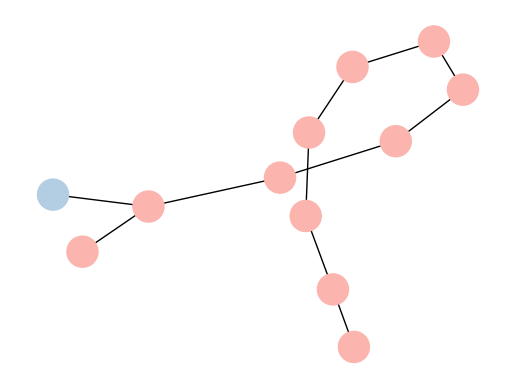

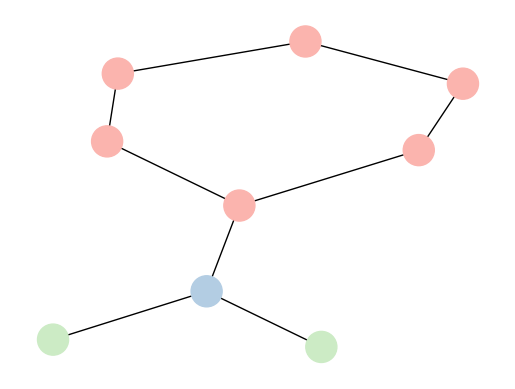

In [61]:
(graph1, graph2, attentions) = torch.load("mutag_new.pt")

summary = loop(graph1, graph2, attentions, 0.05)

nx_graph1 = to_networkx(graph1, to_undirected=True)
nx_graph2 = to_networkx(graph2, to_undirected=True)
ismags = nx.isomorphism.ISMAGS(nx_graph1, nx_graph2)

largest_common_subgraph = list(ismags.largest_common_subgraph())

plot_mutag(create_subgraphs(largest_common_subgraph[0], graph1, graph2)[0])

plot_mutag(summary)

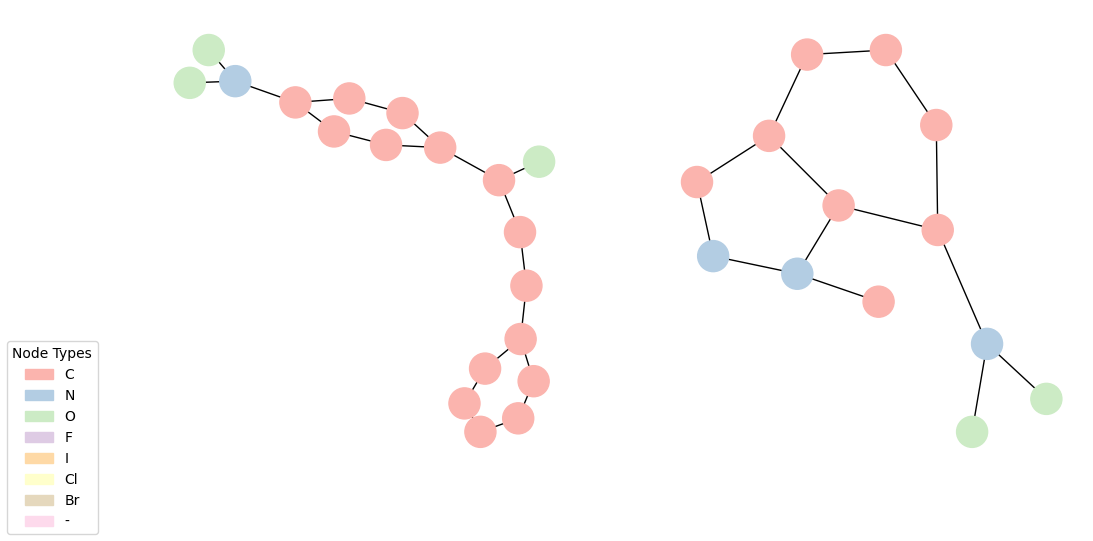

In [63]:
plot_mutag(graph1, graph2)
# plot_mutag(summary)

In [38]:
def plot_attentions_mutag(graph1, graph2, attention_pairs, title="", pos=None):
    colormap = matplotlib.colormaps.get_cmap("Pastel1")
    color_map = {
        0: colormap(0),
        1: colormap(1),
        2: colormap(2),
        3: colormap(3),
        4: colormap(4),
        5: colormap(5),
        6: colormap(6),
        "other": colormap(7),
    }

    def get_node_colors(graph):
        node_colors = []
        for node in range(graph.num_nodes):
            one_hot = graph.x[node].tolist()
            try:
                node_type = one_hot.index(1)
            except ValueError:
                node_type = "other"
            node_colors.append(color_map[node_type])
        return node_colors

    def get_node_labels(graph):
        node_labels = {}
        for node in range(graph.num_nodes):
            node_labels[node] = node
        return node_labels

    G1 = to_networkx(graph1, to_undirected=True)
    G2 = to_networkx(graph2, to_undirected=True)

    G_combined = nx.Graph()

    for n, d in G1.nodes(data=True):
        G_combined.add_node(n, **d)
    for n, d in G2.nodes(data=True):
        G_combined.add_node(n + len(G1.nodes), **d)

    G_combined.add_edges_from([(u, v) for u, v in G1.edges()])
    G_combined.add_edges_from(
        [(u + len(G1.nodes), v + len(G1.nodes)) for u, v in G2.edges()]
    )

    G_original = G_combined.copy()

    for node1, node2 in attention_pairs:
        G_combined.add_edge(node1, node2 + len(G1.nodes))

    pos_G1 = nx.spring_layout(G1)
    pos_G2 = nx.spring_layout(G2)

    for key in pos_G1.keys():
        pos_G1[key] = [pos_G1[key][0] - 1.5, pos_G1[key][1]]

    for key in pos_G2.keys():
        pos_G2[key] = [pos_G2[key][0] + 1.5, pos_G2[key][1]]

    pos_combined = (
        pos if pos else {**pos_G1, **{k + len(G1.nodes): v for k, v in pos_G2.items()}}
    )

    node_colors_G1 = get_node_colors(graph1)
    node_colors_G2 = get_node_colors(graph2)
    node_colors_combined = node_colors_G1 + node_colors_G2

    node_labels_G1 = get_node_labels(graph1)
    node_labels_G2 = get_node_labels(graph2)
    node_labels_combined = {
        **node_labels_G1,
        **{k + len(G1.nodes): v for k, v in node_labels_G2.items()},
    }

    assert len(node_colors_combined) == len(
        G_combined.nodes
    ), "Number of node colors must match the number of nodes in the combined graph."

    plt.figure(figsize=(12, 8))
    nx.draw(
        G_combined,
        pos=pos_combined,
        with_labels=False,
        labels=node_labels_combined,
        node_color=node_colors_combined,
        edge_color="black",
        node_size=500,
    )

    attention_edges = [
        (node1, node2 + len(G1.nodes)) for node1, node2 in attention_pairs
    ]
    nx.draw_networkx_edges(
        G_combined,
        pos=pos_combined,
        edgelist=attention_edges,
        edge_color="lightgrey",
    )

    plt.title(title)
    plt.show()

    return pos_combined

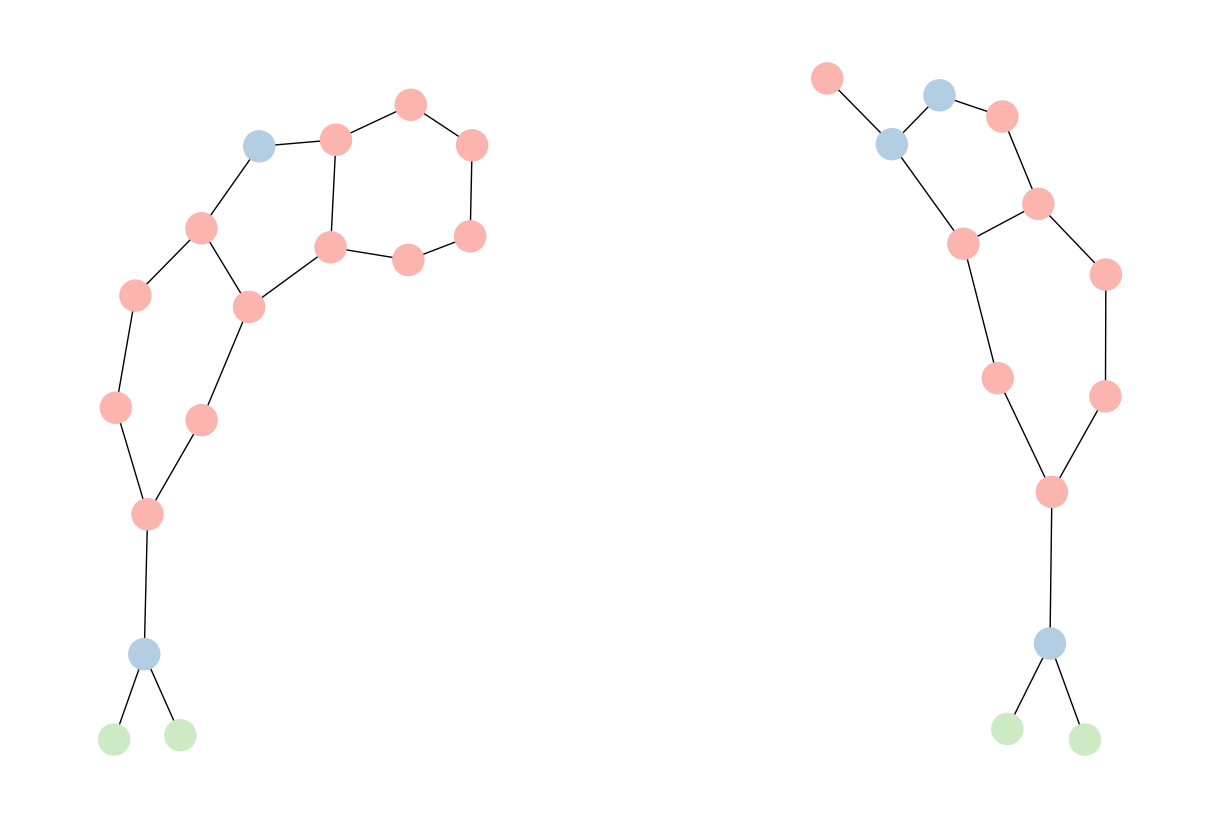

{0: [-0.6568001854025587, 0.28798462626022936],
 1: [-0.6490346967618215, 0.5210223071212781],
 2: [-0.8962079953482553, 0.6246923369686176],
 3: [-1.1977828149256304, 0.5351828590293972],
 4: [-1.5075433335811779, 0.5184090491844102],
 5: [-1.740430238601758, 0.3084746031634153],
 6: [-2.006591236094474, 0.13629370972361293],
 7: [-2.0853562215273618, -0.15067297193804488],
 8: [-1.957574898938961, -0.4233912451059734],
 9: [-1.7395008490956025, -0.1824387426872333],
 10: [-1.54831109973994, 0.10732562547714139],
 11: [-1.2195524774494921, 0.25990640262182396],
 12: [-0.9061079740701361, 0.22746872889883268],
 13: [-1.9710852146354918, -0.7813428753490235],
 14: [-1.8256626721098712, -0.9889144133684833],
 15: [-2.0924580917174667, -1.0],
 16: [0.7829338926010486, 0.692133794216482],
 17: [1.043477715444163, 0.5237529411771529],
 18: [1.3319756131007998, 0.26894569303478],
 19: [1.4704586053379585, -0.07511936523978446],
 20: [1.6888269613029212, -0.36608906064435087],
 21: [1.9047196

In [43]:
plot_attentions_mutag(graph1, graph2, [], pos=pos)

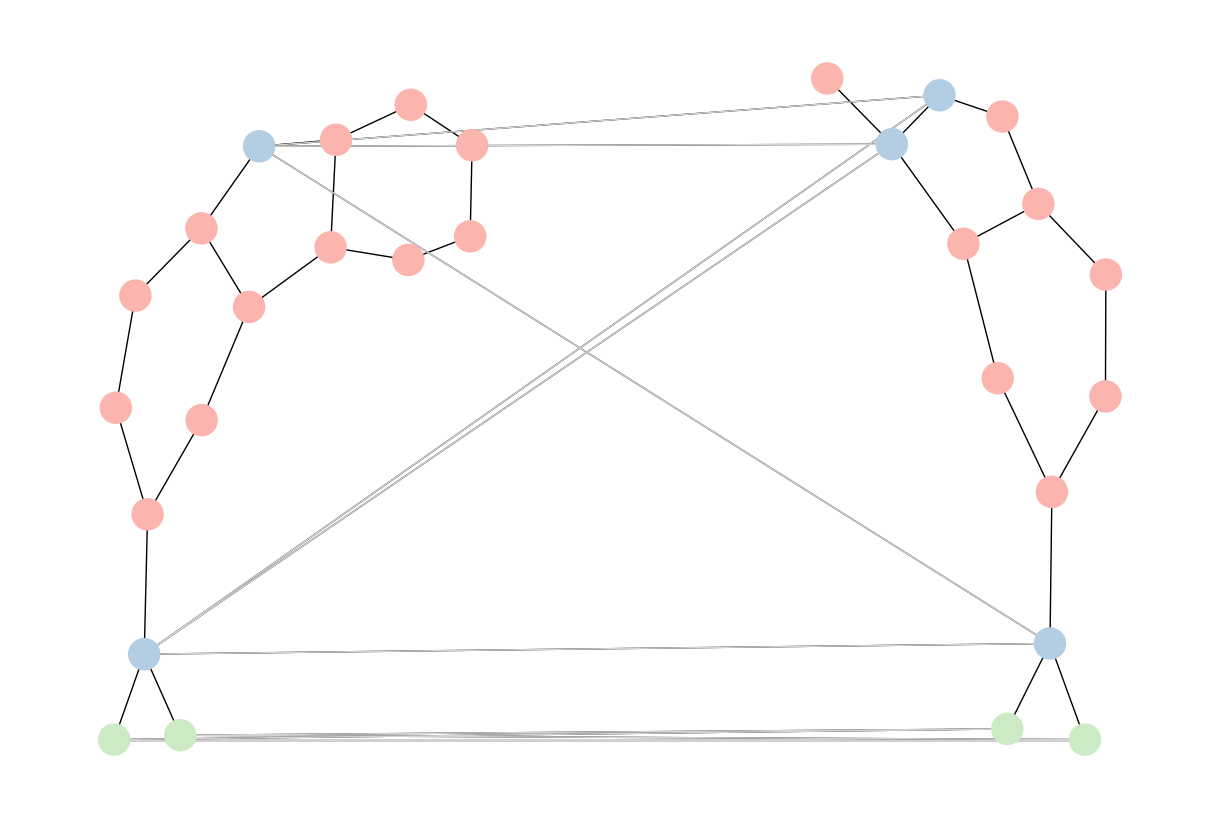

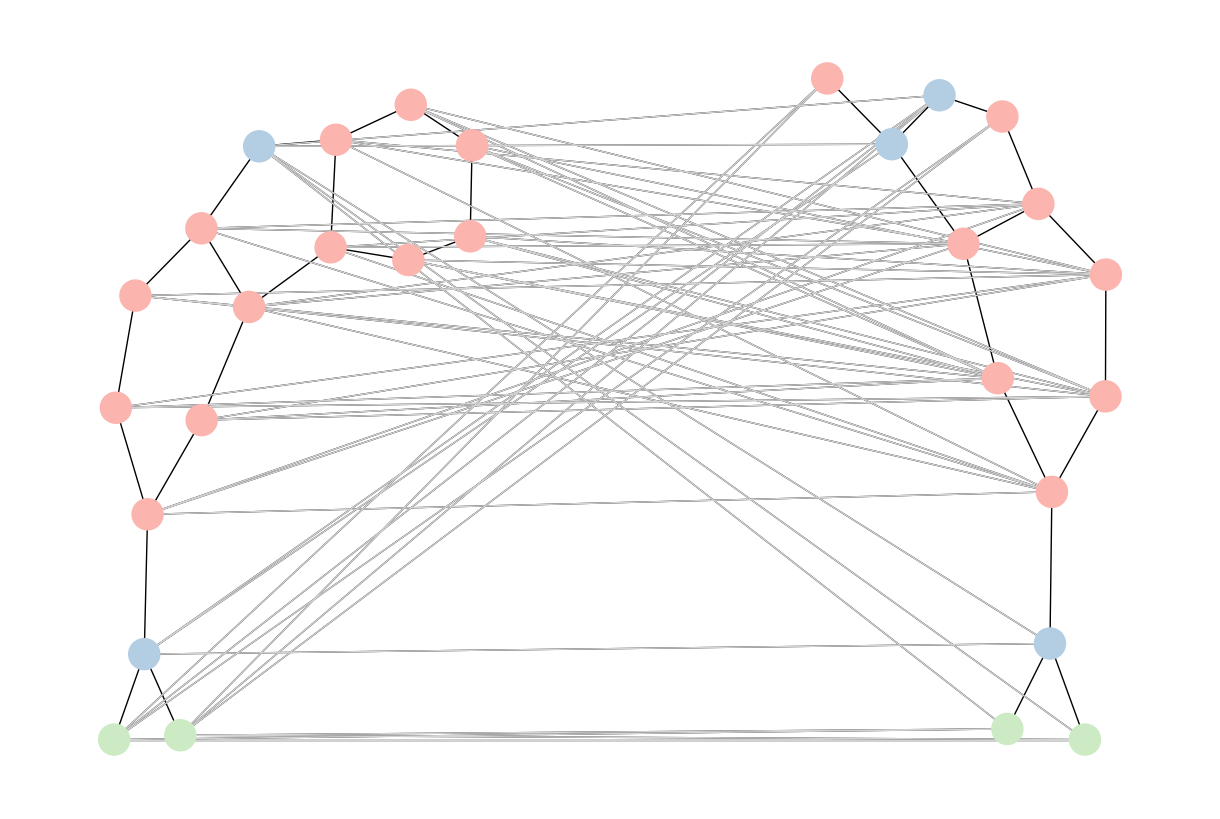

{0: [-0.6568001854025587, 0.28798462626022936],
 1: [-0.6490346967618215, 0.5210223071212781],
 2: [-0.8962079953482553, 0.6246923369686176],
 3: [-1.1977828149256304, 0.5351828590293972],
 4: [-1.5075433335811779, 0.5184090491844102],
 5: [-1.740430238601758, 0.3084746031634153],
 6: [-2.006591236094474, 0.13629370972361293],
 7: [-2.0853562215273618, -0.15067297193804488],
 8: [-1.957574898938961, -0.4233912451059734],
 9: [-1.7395008490956025, -0.1824387426872333],
 10: [-1.54831109973994, 0.10732562547714139],
 11: [-1.2195524774494921, 0.25990640262182396],
 12: [-0.9061079740701361, 0.22746872889883268],
 13: [-1.9710852146354918, -0.7813428753490235],
 14: [-1.8256626721098712, -0.9889144133684833],
 15: [-2.0924580917174667, -1.0],
 16: [0.7829338926010486, 0.692133794216482],
 17: [1.043477715444163, 0.5237529411771529],
 18: [1.3319756131007998, 0.26894569303478],
 19: [1.4704586053379585, -0.07511936523978446],
 20: [1.6888269613029212, -0.36608906064435087],
 21: [1.9047196

In [42]:
# attention_nodes = extract_dynamic_attention_nodes(attentions, threshold=0.07)
mp = mutual_pairs(attention_nodes, 0)

pos = plot_attentions_mutag(graph1, graph2, mp)

mp = mutual_pairs(attention_nodes, 1)
plot_attentions_mutag(graph1, graph2, mp, pos=pos)